In [1]:
! rm -r runs

import gym
import gym_point
import numpy as np
from collections import deque
import torch
import torch.optim as optim

from util import PGN, RewardNet, GRL, float32_preprocessor

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
GAMMA = 0.95
LEARNING_RATE = 0.0001
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
env = gym.make('PointContinuousEnv-v0')
env.set_curve('S') # Curve: 'S', 'C'
env.set_reset_condition('origin') # reset state: 'origin', 'random'

agent_net = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net = RewardNet(env.observation_space.shape[0] + 1)

optimizer_agent = optim.Adam(agent_net.parameters(), lr=LEARNING_RATE)
optimizer_reward = optim.Adam(reward_net.parameters(), lr=1e-4, weight_decay=1e-3)

/home/sagrawal/src/gym/gym/logger.py:30: UserWarning: WARN: The dimensions are bigger than 2, only the first 2 dimensions are visualized
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
agent_net.to(device)
reward_net.to(device)

RewardNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Total number of demonstrations:  100
Total number of step demonstrations:  10000
Testing demonstrations
Test case:  0  Reward:  65 info:  reached end
Test case:  20  Reward:  78 info:  reached end
Test case:  40  Reward:  56 info:  reached end
Test case:  60  Reward:  65 info:  reached end
Test case:  80  Reward:  72 info:  reached end
Average over  5  samples =  67.2


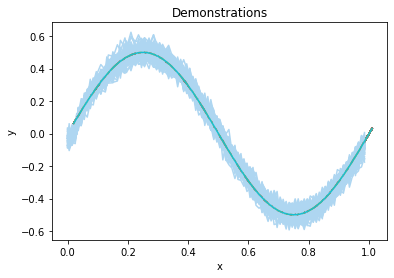

In [5]:
grl = GRL(env, noise=0.03)
demonstrations, XStore_steps, AStore_steps = grl.get_demonstrations(Ndemo=100, Kp=-100, Kd=-3)
grl.test_demonstrations(demonstrations, Nsamp=5, render=False)
# demonstrations['states'][0][:10], demonstrations['actions'][0][:10]

In [6]:
total_rewards = []
step_idx = 0
done_episodes = 0
DEMO_BATCH = 256
BSIZE = 256 # batch size

batch_episodes = 0
batch_states, batch_actions, batch_qvals = deque([], BSIZE), deque([], BSIZE), deque([], BSIZE)
net_rewards = deque([], 100)
env_rewards = deque([], 100)
loss_rwd = 0.

while done_episodes < 500000:
    states, actions, rewards, done = agent_net.generate_session(env, BSIZE)
    
    # Store samples in batch
    batch_states.extend(states)
    batch_actions.extend(actions)
    batch_qvals.extend(grl.calc_qvals(rewards))
    env_reward = np.sum(rewards)
    env_rewards.extend([env_reward])
    
    if len(batch_actions) < BSIZE:
        continue
    
    batch_episodes += 1
        
    # Get reward from reward_net
    x = torch.cat((float32_preprocessor(states), float32_preprocessor(actions).view(-1,1)), dim=1).to(device)
    net_reward = reward_net(x)
    net_rewards.extend([np.sum(net_reward.cpu().detach().numpy())])
         
    done_episodes += 1

    mean_env_rewards = float(np.mean(env_rewards))
    mean_net_rewards = float(np.mean(net_rewards))

    writer.add_scalar('Episodic Reward', env_reward, done_episodes)
    writer.add_scalar('mean_env_reward', mean_env_rewards, done_episodes)
    writer.add_scalar('mean_net_reward', mean_net_rewards, done_episodes)
    writer.add_scalar('loss_reward_net', loss_rwd, done_episodes)        

    print(f'{done_episodes}: reward: {env_reward:6.2f}, mean_env_reward: {mean_env_rewards:6.2f}, mean_net_reward: {mean_net_rewards:6.2f}, reward function loss: {loss_rwd:6.4f}')

    ## Tensorboard logging 
    if done_episodes%1000==0 or mean_env_rewards>=100:
        fig = reward_net.visualize_net(agent_net, Npoints=20)
        writer.add_figure('Reward Net', fig, global_step=done_episodes/100)
        
        test_reward, test_fig = agent_net.test_agent(env,device)
        writer.add_scalar('test_reward', test_reward, done_episodes)
        writer.add_figure('Agent traj', test_fig, global_step=done_episodes/100)
        torch.save(agent_net.state_dict(), 'pointspace_policy_net_origin.mod')
        torch.save(reward_net.state_dict(), 'pointspace_reward_net_origin.mod')

    if mean_env_rewards >= 100:
        print(f'Solved in {step_idx} steps and {done_episodes} episodes!')
        torch.save(agent_net.state_dict(), 'pointspace_policy_net_origin.mod')
        torch.save(reward_net.state_dict(), 'pointspace_reward_net_origin.mod')
        break

    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)
  
    Total_steps_demo = len(AStore_steps)

    # reward function learning
    for rf_i in range(1):
        # ToDo: Sample from initial steps
        selected = np.random.choice(Total_steps_demo, DEMO_BATCH)
        demo_states = np.take(XStore_steps, selected, axis=0)
        demo_actions = np.take(AStore_steps, selected, axis=0)
        
        demo_batch_states = torch.FloatTensor(demo_states)
        demo_batch_actions = torch.FloatTensor(demo_actions)
        
        D_demo = torch.cat([demo_batch_states, demo_batch_actions.view(-1, 1)], dim=-1).to(device)
        D_samp = torch.cat([states_v, batch_actions_t.float().view(-1, 1)], dim=-1).to(device)
        D_samp = torch.cat([D_demo, D_samp])
                
        # dummy importance weights - fix later
        z = torch.ones((D_samp.shape[0], 1)).to(device)

        # objective
        D_demo_out = reward_net(D_demo)
        D_samp_out_net = reward_net(D_samp)
        D_samp_out = z * torch.exp(D_samp_out_net)
        
        loss_rwd = -torch.mean(D_demo_out) + torch.log(torch.mean(D_samp_out))
        optimizer_reward.zero_grad()
        loss_rwd.backward()
        optimizer_reward.step()
    
    # agent
    optimizer_agent.zero_grad()
    logits_v = agent_net(states_v.to(device))
    log_prob_v = torch.log_softmax(logits_v.cpu(), dim=1) # p(a|s)
    
    # batch_qvals_v = E(s)
    # REINFORCE
    log_prob_actions_v = -batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t] #q(s,a)=p(a|s)E(s)
    loss_v = log_prob_actions_v.mean()
    writer.add_scalar('loss_agent_net', loss_v, done_episodes) 
    
    loss_v.backward()
    optimizer_agent.step()

    batch_episodes = 0

env.close()
writer.close()

1: reward:   1.00, mean_env_reward:   1.00, mean_net_reward:  58.77, reward function loss: 0.0000
2: reward:   3.00, mean_env_reward:   1.50, mean_net_reward:  59.17, reward function loss: -0.0322
3: reward:   2.00, mean_env_reward:   1.60, mean_net_reward:  56.01, reward function loss: -0.0369
4: reward:   1.00, mean_env_reward:   1.50, mean_net_reward:  59.21, reward function loss: -0.0779
5: reward:   1.00, mean_env_reward:   1.43, mean_net_reward:  56.13, reward function loss: -0.0720
6: reward:   2.00, mean_env_reward:   1.50, mean_net_reward:  54.79, reward function loss: -0.1084
7: reward:   1.00, mean_env_reward:   1.44, mean_net_reward:  55.75, reward function loss: -0.1224
8: reward:   1.00, mean_env_reward:   1.40, mean_net_reward:  52.04, reward function loss: -0.1397
9: reward:   2.00, mean_env_reward:   1.45, mean_net_reward:  49.63, reward function loss: -0.1723
10: reward:   1.00, mean_env_reward:   1.42, mean_net_reward:  49.28, reward function loss: -0.2147
11: reward

85: reward:   1.00, mean_env_reward:   1.18, mean_net_reward:  26.24, reward function loss: -0.3197
86: reward:   1.00, mean_env_reward:   1.18, mean_net_reward:  26.05, reward function loss: -0.3438
87: reward:   2.00, mean_env_reward:   1.19, mean_net_reward:  25.80, reward function loss: -0.3447
88: reward:   1.00, mean_env_reward:   1.19, mean_net_reward:  25.55, reward function loss: -0.3443
89: reward:   1.00, mean_env_reward:   1.19, mean_net_reward:  25.33, reward function loss: -0.3577
90: reward:   2.00, mean_env_reward:   1.20, mean_net_reward:  25.07, reward function loss: -0.3561
91: reward:   1.00, mean_env_reward:   1.19, mean_net_reward:  24.82, reward function loss: -0.3604
92: reward:   5.00, mean_env_reward:   1.23, mean_net_reward:  24.81, reward function loss: -0.3679
93: reward:   1.00, mean_env_reward:   1.23, mean_net_reward:  24.60, reward function loss: -0.3321
94: reward:   1.00, mean_env_reward:   1.23, mean_net_reward:  24.72, reward function loss: -0.3281


167: reward:   1.00, mean_env_reward:   1.34, mean_net_reward:  11.35, reward function loss: -0.3646
168: reward:   1.00, mean_env_reward:   1.34, mean_net_reward:  11.34, reward function loss: -0.3660
169: reward:   1.00, mean_env_reward:   1.34, mean_net_reward:  10.95, reward function loss: -0.3673
170: reward:   1.00, mean_env_reward:   1.34, mean_net_reward:  10.67, reward function loss: -0.3580
171: reward:   2.00, mean_env_reward:   1.35, mean_net_reward:  10.59, reward function loss: -0.3657
172: reward:   2.00, mean_env_reward:   1.36, mean_net_reward:  10.44, reward function loss: -0.3608
173: reward:   1.00, mean_env_reward:   1.36, mean_net_reward:  10.44, reward function loss: -0.3543
174: reward:   1.00, mean_env_reward:   1.36, mean_net_reward:  10.25, reward function loss: -0.3602
175: reward:   1.00, mean_env_reward:   1.36, mean_net_reward:   9.91, reward function loss: -0.3694
176: reward:   6.00, mean_env_reward:   1.41, mean_net_reward:   9.98, reward function loss

KeyboardInterrupt: 

In [ ]:
## Testing 
agent_net.eval()

for i in range(10):
    state = env.reset()
    Reward = 0
    done = False
    while not done:
        env.render()
        action, _ = agent_net.get_action(state)
        state, reward, done, _ = env.step(int(action))
        Reward += reward
    print("Trial :", i, " Reward: ", Reward)
env.close()